# Import Libraries

In [39]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause
import seaborn as sns
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression

sns.set_theme(style='white')

# ML Sklearn

## Load Datasets

In [40]:
import os
os.getcwd()

'c:\\Users\\flourenco\\Desktop\\Methylation_Project\\Code'

In [41]:
#input_path = '../../share/Methylation_Project_FM_FS/Data/'
input_path = '../Data/Processed_Data/'
output_path = input_path

In [42]:
import pandas as pd

x_train = pd.read_pickle(input_path+'embedding.pkl')
x_test = pd.read_pickle(input_path+'embedding_test.pkl')

y = pd.read_csv(input_path+'y.csv', index_col=0)

y_train = y[~y['Clinical Trial'].isin(['AML02','AML08'])]
y_train = y_train[y_train['os.evnt'].notnull()]
y_test = y[y['Clinical Trial'].isin(['AML02','AML08'])]

# Select samples in x that are in y_trai

x_train = x_train.loc[y_train.index].to_numpy()
x_test = x_test.loc[y_test.index].to_numpy()

# Standardize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

X = np.concatenate((x_train, x_test))

y_test.shape, y_train.shape

((200, 299), (1093, 299))

## Hyperparameter tuning by GridSearch

### Nearest Neighbors

In [43]:
parameters = {
    'n_neighbors': [2, 3, 5, 8, 10],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance'],
}

estimator = KNeighborsClassifier()

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    cv = 5,
    verbose=True
)

grid_search.fit(x_train,y_train['os.evnt'])

model = grid_search.best_estimator_.fit(x_train,y_train['os.evnt'])
knn = grid_search.best_estimator_

print('COG OS ROC AUC: %.3f ' % (model.score(x_train,y_train['os.evnt'])))
print('StJude OS ROC AUC: %.3f ' % (model.score(x_test,y_test['os.evnt'])))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
COG OS ROC AUC: 0.731 
StJude OS ROC AUC: 0.680 


### Radial Basis Function (RBF) SVM 

In [44]:
parameters = {
    'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
        
}

estimator = SVC()

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    cv = 5,
    verbose=True
)

grid_search.fit(x_train,y_train['os.evnt'])

model = grid_search.best_estimator_.fit(x_train,y_train['os.evnt'])
rbf_svm = grid_search.best_estimator_

print('COG OS ROC AUC: %.3f ' % (model.score(x_train,y_train['os.evnt'])))
print('StJude OS ROC AUC: %.3f ' % (model.score(x_test,y_test['os.evnt'])))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
COG OS ROC AUC: 0.691 
StJude OS ROC AUC: 0.610 


### Gaussian Process

In [45]:
parameters = {
    'max_iter_predict': [100, 200, 500, 1000],

}

estimator = GaussianProcessClassifier()

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    cv = 5,
    verbose=True
)

grid_search.fit(x_train,y_train['os.evnt'])

model = grid_search.best_estimator_.fit(x_train,y_train['os.evnt'])
gpc = grid_search.best_estimator_

print('COG OS ROC AUC: %.3f ' % (model.score(x_train,y_train['os.evnt'])))
print('StJude OS ROC AUC: %.3f ' % (model.score(x_test,y_test['os.evnt'])))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
COG OS ROC AUC: 0.654 
StJude OS ROC AUC: 0.690 


### Random Forest

In [59]:
parameters = {

'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

#     'bootstrap': [True, False],
#     'min_samples_leaf': [1, 2, 4],
#     'min_samples_split': [2, 5, 10],
#     'n_estimators': [200, 400]
# }

estimator = RandomForestClassifier()

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    cv = 5,
    verbose=True
)

grid_search.fit(x_train,y_train['os.evnt'])

model = grid_search.best_estimator_.fit(x_train,y_train['os.evnt'])
rfc = grid_search.best_estimator_

best_model = grid_search.best_estimator_.fit(x_train,y_train['os.evnt'])

print('COG OS ROC AUC: %.3f ' % (model.score(x_train,y_train['os.evnt'])))
print('StJude OS ROC AUC: %.3f ' % (model.score(x_test,y_test['os.evnt'])))

Fitting 5 folds for each of 1980 candidates, totalling 9900 fits
COG OS ROC AUC: 0.825 
StJude OS ROC AUC: 0.630 


### Neural Net

In [47]:
parameters = {
    'hidden_layer_sizes': [(100,), (200,), (50,), (100, 50,)],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
}

estimator = MLPClassifier(activation='tanh', solver='adam', random_state=42, max_iter=500)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    cv = 5,
    verbose=True
)

grid_search.fit(x_train,y_train['os.evnt'])

model = grid_search.best_estimator_.fit(x_train,y_train['os.evnt'])
mlp = grid_search.best_estimator_

print('COG OS ROC AUC: %.3f ' % (model.score(x_train,y_train['os.evnt'])))
print('StJude OS ROC AUC: %.3f ' % (model.score(x_test,y_test['os.evnt'])))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
COG OS ROC AUC: 0.672 
StJude OS ROC AUC: 0.635 


In [48]:
mlp

MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 50), max_iter=500,
              random_state=42)

### Quadratic Discriminant Analysis

In [49]:
parameters = {
    'reg_param': [0.0, 0.1, 0.2, 0.3, 0.5],
    'tol': [1e-4, 1e-2, 1, 10]
}

estimator = QuadraticDiscriminantAnalysis()

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    cv = 5,
    verbose=True
)

grid_search.fit(x_train,y_train['os.evnt'])

model = grid_search.best_estimator_.fit(x_train,y_train['os.evnt'])
qda = grid_search.best_estimator_

print('COG OS ROC AUC: %.3f ' % (model.score(x_train,y_train['os.evnt'])))
print('StJude OS ROC AUC: %.3f ' % (model.score(x_test,y_test['os.evnt'])))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
COG OS ROC AUC: 0.636 
StJude OS ROC AUC: 0.705 


### XGBoost

In [50]:
parameters = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],
    'max_depth': range(2, 6, 10),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1, 10]
}

estimator = xgb.XGBClassifier(objective='binary:logistic', seed=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    cv = 5,
    verbose=True
)

grid_search.fit(x_train,y_train['os.evnt'])

model = grid_search.best_estimator_.fit(x_train,y_train['os.evnt'])
xgb = grid_search.best_estimator_

print('COG OS ROC AUC: %.3f ' % (model.score(x_train,y_train['os.evnt'])))
print('StJude OS ROC AUC: %.3f ' % (model.score(x_test,y_test['os.evnt'])))

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
COG OS ROC AUC: 0.767 
StJude OS ROC AUC: 0.630 


### Logistic Regression

In [51]:
parameters = {
    'tol': [1e-4, 1e-2, 1, 10],
    'C': [0.5, 1.0, 1.5],
    'max_iter': [100, 200],
    'multi_class': ['auto', 'ovr', 'multinomial'],
    'class_weight': ['balanced', None],
}

estimator = LogisticRegression(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    cv = 5,
    verbose=True
)

grid_search.fit(x_train,y_train['os.evnt'])

model = grid_search.best_estimator_.fit(x_train,y_train['os.evnt'])
lr = grid_search.best_estimator_

print('COG OS ROC AUC: %.3f ' % (model.score(x_train,y_train['os.evnt'])))
print('StJude OS ROC AUC: %.3f ' % (model.score(x_test,y_test['os.evnt'])))

Fitting 5 folds for each of 144 candidates, totalling 720 fits
COG OS ROC AUC: 0.636 
StJude OS ROC AUC: 0.705 


In [52]:
print('COG OS ROC AUC: %.3f ' % (model.score(x_train,y_train['os.evnt'])))
print('StJude OS ROC AUC: %.3f ' % (model.score(x_test,y_test['os.evnt'])))

COG OS ROC AUC: 0.636 
StJude OS ROC AUC: 0.705 


## Define Classifiers

In [53]:
names = [
    "Nearest Neighbors",
    "RBF SVM",
    "Gaussian Process",
    "Random Forest",
    "Neural Net",
    "QDA",
    "XGBoost",
    "Logistic Regression"
]

classifiers = [
    knn,
    rbf_svm,
    gpc,
    rfc,
    mlp,
    qda,
    xgb,
    lr
]

## Plot classifiers

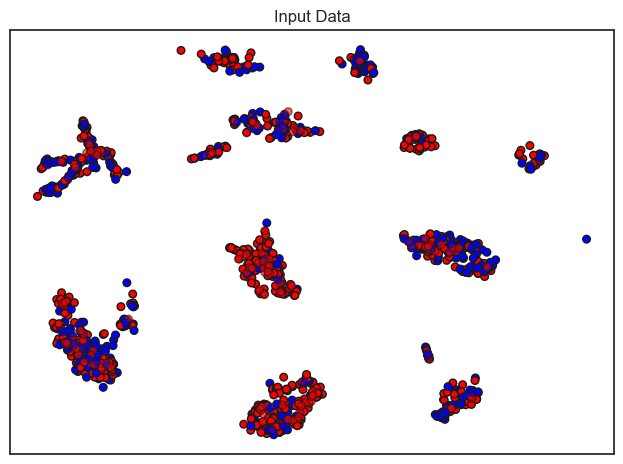

In [54]:
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cm = plt.cm.RdBu

ax = plt.subplot() 
# Plot the training points
ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train["os.evnt"], cmap=cm_bright, edgecolors="k", s=30)
# Plot the testing points
ax.scatter(
    x_test[:, 0], x_test[:, 1], c=y_test["os.evnt"], cmap=cm_bright, alpha=0.6, edgecolors="k", s=30
)

ax.set_xticks(())
ax.set_yticks(())
ax.set_title("Input Data")

plt.tight_layout()
plt.show()

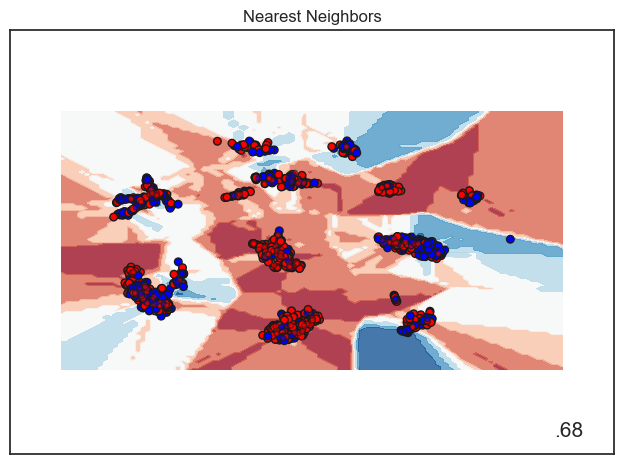

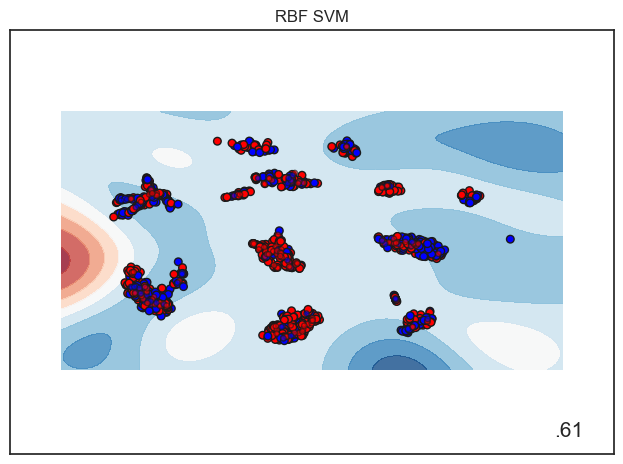

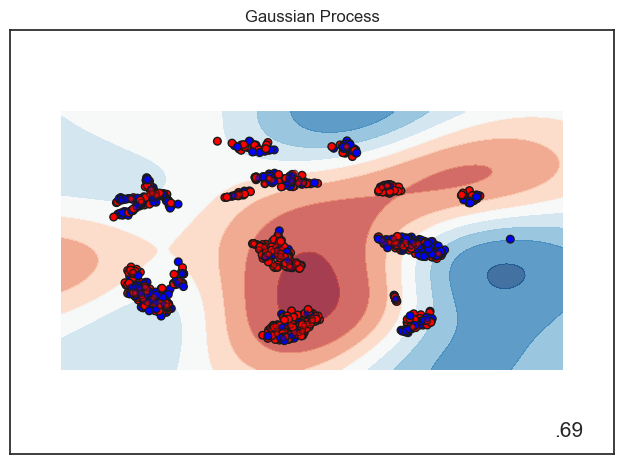

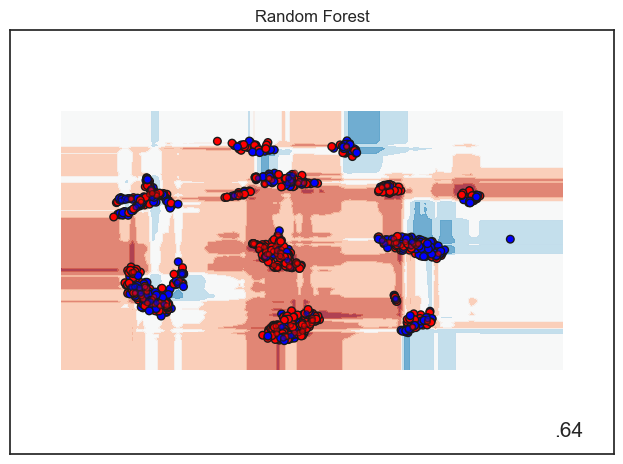

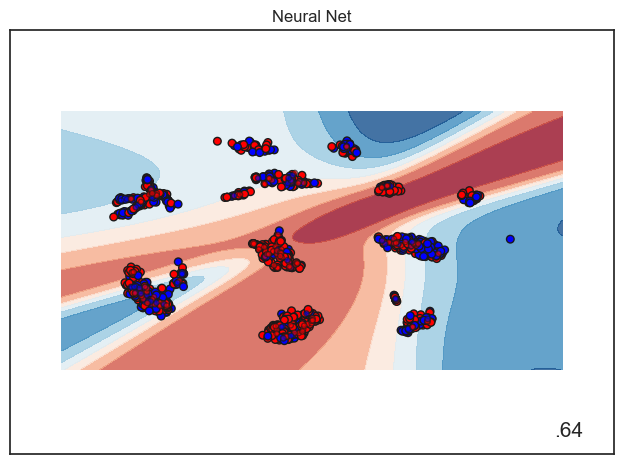

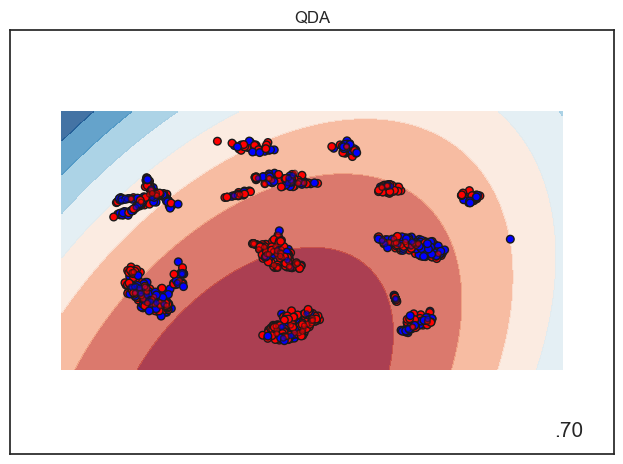

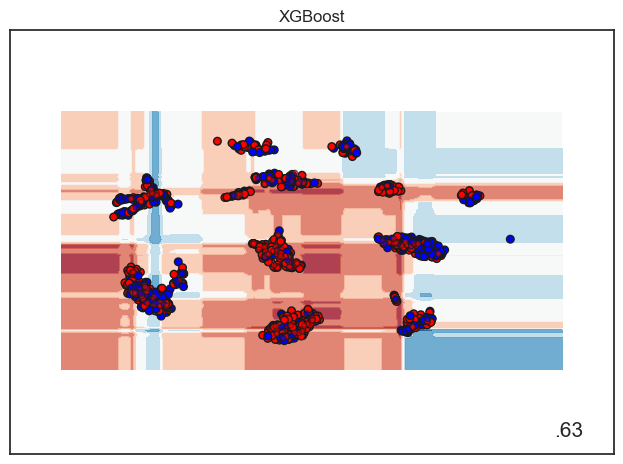

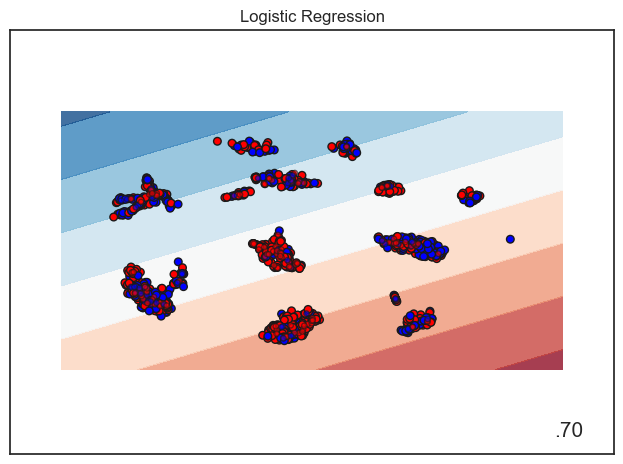

In [55]:
for name, clf in zip(names, classifiers):
    ax = plt.subplot() 

    x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
    y_min, y_max = x_test[:, 1].min() - 2, x_test[:, 1].max() + 2


    # Test classifier
    #clf = make_pipeline(StandardScaler(), clf)
    clf.fit(x_train, y_train["os.evnt"])
    score = clf.score(x_test, y_test["os.evnt"])
    DecisionBoundaryDisplay.from_estimator(
        clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
    )

    # Plot the points
    ax.scatter(
        x_train[:, 0], x_train[:, 1], c=y_train["os.evnt"], cmap=cm_bright, edgecolors="k", s=30
    )

    ax.scatter(
        x_test[:, 0], 
        x_test[:, 1], 
        c=y_test["os.evnt"], 
        cmap=cm_bright, 
        alpha=0.6, 
        edgecolors="k", 
        s=15
    )

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)

    ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    plt.tight_layout()
    plt.show()

In [56]:
y_train['MethylScore'] = model.predict(x_train)
y_train['MethylScore Categorical'] = y_train['MethylScore'].map({1:'High', 0:'Low'})
y_train['MethylScore_cat_bin'] = y_train['MethylScore']

y_test['MethylScore'] = model.predict(x_test)
y_test['MethylScore Categorical'] = y_test['MethylScore'].map({1:'High', 0:'Low'})
y_test['MethylScore_cat_bin'] = y_test['MethylScore']

C:\Users\flourenco\AppData\Local\Temp\ipykernel_2444\33214688.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['MethylScore'] = model.predict(x_test)
C:\Users\flourenco\AppData\Local\Temp\ipykernel_2444\33214688.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['MethylScore Categorical'] = y_test['MethylScore'].map({1:'High', 0:'Low'})
C:\Users\flourenco\AppData\Local\Temp\ipykernel_2444\33214688.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

## Save File

In [57]:
# Save y_train and y_test in the same file
y = pd.concat([y_train, y_test])
y.to_csv(output_path+'y_MethylScore.csv')